# Example notebook: BP Prediction
This example notebook uses both the `features.tsv` and `participants.tsv` files in the `sample` data directory.

In [1]:
# Imports.
import os.path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, model_selection

In [2]:
# Location of 'sample' data directory.
DATA_DIR=os.path.join('..', 'sample')

In [3]:
# Load as dataframes, and join features/participants files on pid field.
ppt_df = pd.read_csv(os.path.join(DATA_DIR, 'participants.tsv'), delimiter='\t')
feat_df = pd.read_csv(os.path.join(DATA_DIR, 'features.tsv'), delimiter='\t')
comb_df = ppt_df.merge(feat_df, how='left', left_on='pid', right_on='pid')

# View key aspects of combined dataframe: participant id (pid), study phase, and measurement within phase.
comb_df[['pid', 'phase', 'measurement']]

,pid,phase,measurement
0,o000,ambulatory,measurement 23
1,o000,ambulatory,measurement 25
2,o000,ambulatory,measurement 27
3,o000,ambulatory,measurement 28
4,o000,ambulatory,measurement 30
...,...,...,...
382,a005,return,Temporal challenge start 1
383,a005,return,Temporal challenge start 2
384,a005,return,Temporal challenge start 3
385,a005,synthetic,Calibration average values


In [4]:
# Show alphabetized list of features (see paper for details).
feature_list = list(comb_df.columns)
feature_list.sort()
print(feature_list)

['age', 'aix_pressure', 'aortic_stenosis', 'arm_angle', 'arrythmia', 'aurora_size', 'baseline_dbp', 'baseline_sbp', 'beat_length_ekg', 'bp_cuff_arm', 'coronary_artery_disease', 'cvd_meds', 'date_time', 'dbp', 'delta_aix_pressure', 'delta_arm_angle', 'delta_beat_length_ekg', 'delta_dbp', 'delta_dicrotic_notch_height_pressure', 'delta_dpdt_optical', 'delta_dpdt_pressure', 'delta_ejection_duration_fraction_pressure', 'delta_ejection_duration_pressure', 'delta_hr_ekg', 'delta_hr_optical', 'delta_hr_pressure', 'delta_hrv_ekg', 'delta_invpat_optical', 'delta_invpat_pressure', 'delta_quality_optical', 'delta_quality_pressure', 'delta_rpat_optical', 'delta_rpat_pressure', 'delta_rwat_pressure', 'delta_sbp', 'delta_sysrise_pressure', 'diabetes', 'dicrotic_notch_height_pressure', 'dpdt_optical', 'dpdt_pressure', 'ejection_duration_fraction_pressure', 'ejection_duration_pressure', 'fitzpatrick_scale', 'gender', 'heart_failure', 'height', 'high_blood_pressure', 'hr_ekg', 'hr_optical', 'hr_pressure

In [5]:
# Set up features.
indep_features = ['baseline_sbp', 'age', 'weight', 'height', 'delta_hr_ekg', 'delta_rpat_pressure']
target_feature = 'delta_sbp' # For an easier target, try 'delta_hr_pressure'.

# Subset dataframe to contain only the ambulatory measurements by restricting 'phase'.
ambulatory_df = comb_df.loc[comb_df['phase'] == 'ambulatory']
cv_df = ambulatory_df.dropna(how='any', subset=indep_features+[target_feature])

# Compute unique set of participants.
ppts = set(cv_df['pid'])
print(f'{len(ppts)} participants, {cv_df.shape[0]} total rows.')

5 participants, 141 total rows.


In [6]:
# Cross-validation loop over folds per participant. It is essential to stratify by participant vs. by row, 
# i.e., the training data for a given participant must not contain samples from that participant, since in 
# realistic problem settings we will not have access to other ambulatory values for that participant.
# 
# The fold strategy below can also be achieved with sklearn's model_selection.LeaveOneGroupOut, but we construct 
# the groups manually in order to make the stratification clear.
test_df_list = []
# Choose a model type.
model = linear_model.Ridge(alpha=0.001)
# Iterate over participants.
for ppt in ppts:
    # Training subset.
    fold_train_df = cv_df.loc[cv_df['pid'] != ppt]
    # Create deep copy for test subset, since we'll be adding a column.
    fold_test_df = pd.DataFrame(cv_df.loc[cv_df['pid'] == ppt])
    # Fit model based on training subset.
    model.fit(fold_train_df[indep_features], fold_train_df[target_feature])
    # Add 'model_prediction' column to fold_test_df, containing predictions on test subset.
    fold_test_df['model_prediction'] = model.predict(fold_test_df[indep_features])
    # Append augmented fold_test_df to list for later assembly.
    test_df_list.append(fold_test_df)
# Assemble all fold_test_dfs into new dataframe
predictions_df = pd.concat(test_df_list, axis=0)

Text(0, 0.5, 'Model Prediction')

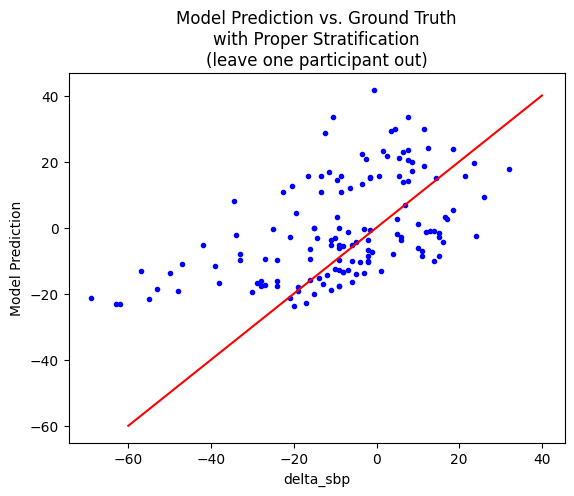

In [7]:
# Plot results vs. ground truth.
plt.plot(predictions_df[target_feature], predictions_df['model_prediction'], 'b.')
plt.plot([-60,40], [-60,40], 'r-')
plt.title('Model Prediction vs. Ground Truth\nwith Proper Stratification\n(leave one participant out)')
plt.xlabel(target_feature)
plt.ylabel('Model Prediction')

Text(0, 0.5, 'False Prediction')

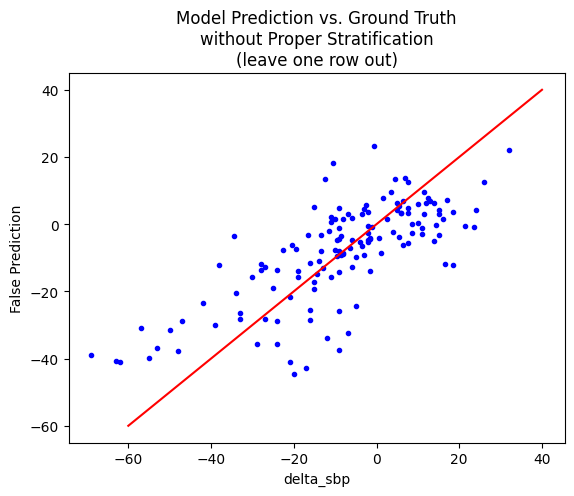

In [8]:
# How would it look if we naively used leave-one-(row)-out cross-validation? We expect this will provide us
# with unrealistically optimistic results, as explained above, and shown below.
demo_df = pd.DataFrame(cv_df)
demo_df['false_prediction'] = model_selection.cross_val_predict(model, demo_df[indep_features], demo_df[target_feature], 
                                                                cv=model_selection.LeaveOneOut())

# Plot results vs. ground truth.
plt.plot(demo_df[target_feature], demo_df['false_prediction'], 'b.')
plt.plot([-60,40], [-60,40], 'r-')
plt.title('Model Prediction vs. Ground Truth\nwithout Proper Stratification\n(leave one row out)')
plt.xlabel(target_feature)
plt.ylabel('False Prediction')